# Notebook 8 - Summary of AVT02 batch functionalities. 

#### This notebook summarises the necessary functionalities of all batches provided in a functionality dataframe that can be used for the network reduction algorithm in Notebook 6. 

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import copy
import cobra
import math
from collections import defaultdict

#### Load DoE data and make the proper adjustments:

In [2]:
# Note: Its three days from addition of original media until the first amount of feed is added. 
# Calculate the MAXIMUM uptake of the media components, set that as upper bound of the associated reactions:

dat = pd.read_excel(
    'C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Modelling/Batch_runs_ALVO/AVT02/DoE runs - USP/All_blocks.xlsx',
    sheet_name='batch_data',engine = 'openpyxl')

# Fix sample code identifiers:
temp_list = dat['sample code'].tolist()
temp_list = [x[:-3] for x in temp_list]
temp_list = [x.replace('-',' ') for x in temp_list]
temp_list = [x.replace(' ','') for x in temp_list]
dat['sample code'] = temp_list
dat['Feed A added (mL)'] = dat['Feed A added (mL)'].fillna(0)
dat['feed B added  (mL)'] = dat['feed B added  (mL)'].fillna(0)
dat.rename(columns={'Gluc (g/L)': 'Glucose', 'Lac (g/L)': 'Lactate','Gln (mM)':'Glutamine','Glu (mM)':'Glutamate',
                   'IgG (g/L)':'IgG','volume culture (mL)':'Volume(mL)','Feed A added (mL)':'Feed_A_ADDED',
                   'feed B added  (mL)':'Feed_B_ADDED','glutamine added (mL)':'Glutamine_ADDED','NH3 (mM)':'NH3',
                   'sample code':'Experiment'},inplace=True)

# Calculate grams of IgG in liter in final product:
dat['IgG'] = dat['IgG'].fillna(0)
dat['Glutamine_ADDED'] = dat['Glutamine_ADDED'].fillna(0)
dat['igg_grams'] = dat['IgG']*(dat['Volume(mL)']/1000)
dat.drop('Day', inplace=True, axis=1)


# Make sure that I only have the first 11 days for all processes. This makes the analysis much easier and more 
# streamlined. 
dat = dat[dat['Hour'] < 270]
dat['Day'] = [0,1,2,3,4,5,6,7,8,9,10,11]*38

C:\Users\sigurdur.karvelsson\Anaconda3\envs\mynewenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


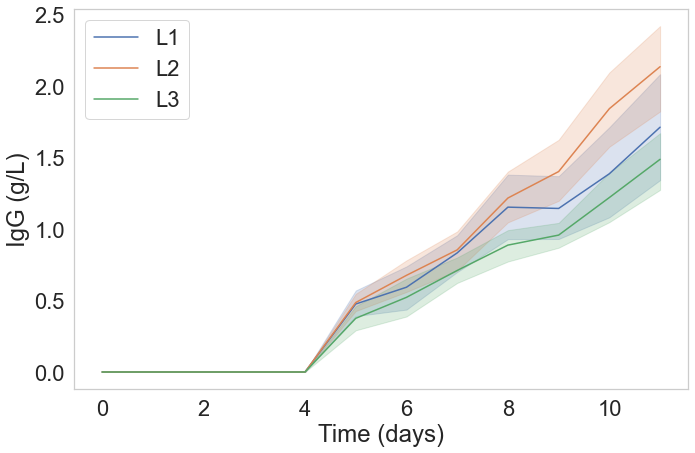

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2)
sns.set_style("whitegrid")
plt.subplots(figsize=(11,7))
plt.grid()  #just add this
sns.lineplot(dat['Day'],dat['IgG'],hue = dat['pH_strategy'])
plt.legend(loc='upper left')
plt.xlabel('Time (days)')
plt.ylabel('IgG (g/L)')
plt.show()

#### Load feed and media information:

In [4]:
feed = pd.read_excel(
    'C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Modelling/Batch_runs_ALVO/AVT02/Media and Feed composition_Alvotech.xlsx',
    sheet_name='data_clean', engine='openpyxl')

# There are multiple measurement of each component in media and feed. Calculate the average value:
media_conc = dict(feed[feed['Feed type'] == 'ACGM'].drop(['Feed type','glucose','glutamine'],axis = 1).mean())
feedA_conc = dict(feed[feed['Feed type'] == 'A'].drop(['Feed type','glutamine'],axis = 1).mean())
feedB_conc = dict(feed[feed['Feed type'] == 'B'].drop(['Feed type','glutamine'],axis = 1).mean())

# Prepare a dictionary of metabolites-to-met_id to use for the MFA:
mets_mapped = pd.read_excel(
    'C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Modelling/Batch_runs_ALVO/AVT02/Media and Feed composition_Alvotech.xlsx',
    sheet_name='met_to_met_id',engine = 'openpyxl')
met_dict = dict(zip(mets_mapped['Metabolite'],mets_mapped['metabolite_id']))

#### Define the MFA class so that the batches may be summarised:

In [5]:
# ALSO: NEED TO REDEFINE THE CALCULATION OF GLUCOSE/GLUTAMINE UPTAKE RATES SO THAT IT ACCOUNTS FOR IVCD, AND NOT VCD. 
class MFA:
    '''
    This class will be to define the media conditions at any given timepoint for the model of interest. 
    It will result in a model representative of a batch, with the timepoints set as options.  
    
    TODO: 
        -Add OXYGEN uptake rates from DO values. 
    
    '''
    def __init__(self,model,batch_record,media_composition,feed_A_composition,feed_B_composition,met_dict):
        import cobra
        from collections import defaultdict
        import numpy as np
        import itertools
        
        self.orig_met_dict = met_dict.copy()
        self.feed_A_composition = feed_A_composition
        self.feed_B_composition = feed_B_composition
        self.batch_record = batch_record
        self.model_orig = model.copy()
        self.model = model
        self.A = cobra.util.array.create_stoichiometric_matrix(self.model,'dense')
        self.rxns = [rxn.id for rxn in self.model.reactions]
        self.mets = [met.id for met in self.model.metabolites]
        self.cell_weight = 350e-12
        self.gln_decomp_rate = 0.0019 # Calculated from experiments. 
        self.media_composition = media_composition
        self.met_list = list(met_dict.values())
        self.days_of_feed_additions = [3,5,7,9] # This is predetermined and is necessary information
        self.process_met_dict = defaultdict(list)
        self.process_met_dict['Glucose'] = ['EX_glc_e__SECRETION','EX_glc_e__UPTAKE']
        self.process_met_dict['Lactate'] = ['EX_lac_L_e__SECRETION','EX_lac_L_e__UPTAKE']
        self.process_met_dict['Glutamine'] = ['EX_gln_L_e__SECRETION','EX_gln_L_e__UPTAKE']
        self.process_met_dict['Glutamate'] = ['EX_glu_L_e__SECRETION','EX_glu_L_e__UPTAKE']
        self.process_met_dict['NH3'] = ['EX_nh4_e__SECRETION','EX_nh4_e__UPTAKE']
        self.process_met_dict['IgG'] = ['DM_AVT02_c']
        self.process_met_dict['VCD'] = ['biomass_cho_producing']

        # Adjust model to extracellular conditions:
        self.adjust_model_to_extracellular_conditions()

        # Now extract the original model constraints, to use later on with other batches:
        self.orig_model_ub = [rxn.upper_bound for rxn in self.model.reactions]
        self.orig_model_lb = [rxn.lower_bound for rxn in self.model.reactions]
            
            
    def adjust_model_to_extracellular_conditions(self):
        '''
        A function to take an original model and add all the necessary uptakes and make the proper adjustments so that it fits
        the media and feed compositions. 
        '''
        # Add necessary extracellular metabolite ids (if lacking)
        for met in self.met_list:
            self.model = self.set_extracellular_environment(met)
        
        # Add uptake reactions (if missing) and re-name current uptake reactions:
        self.model = self.set_necessary_uptakes()
        self.model = self.set_necessary_secretions()
        
        self.met_to_rxn_dict_media = dict()
        for key in self.orig_met_dict:
        #for key in self.met:
            tmp_rxn = self.check_if_uptake_present(self.orig_met_dict[key])
            tmp_rxn1 = self.check_if_secretion_present(self.orig_met_dict[key])
            if not self.check_if_string_in_list(key,list(self.process_met_dict.keys())):
                self.met_to_rxn_dict_media[key] = [tmp_rxn1[0], tmp_rxn[0]]
        return
    
    def check_if_string_in_list(self,string,list_):
        '''
        Function to test whether a string is in a list, discarding whitespace and capitalization:
        '''
        stripped_list = [x.strip().lower() for x in list_]
        if string.strip().lower() in stripped_list:
            status = True
        else:
            status = False
        return status
    
    def find_matching_string(self,string,list_):
        '''
        Function to find the matching string in a list (discarding whitespace and capitalization), given that there is a match.
        Returns matching string in original list.
        '''
        stripped_list = [x.strip().lower() for x in list_]
        idxx = stripped_list.index(string.strip().lower())
        outp = list_[idxx]
        return outp
        
    
    def get_current_IVCD(self,day):
        #import numpy as np
        id_col = self.subdat.columns.get_loc("VCD")
        if day != 0:
            # start with day 1, and calculate the IVCD between days 0 and 1:
            ivcd_tmp_prev = self.subdat.iloc[0,id_col]
            day_curr = 1
            day_prev = 0
            total_ivcd = 0
            while day_curr != day+1:
                # Iterative calculation of IVCD
                id_row = np.where(self.subdat['Day'] == day_curr)[0][0]
                vcd_curr = self.subdat.iloc[id_row,id_col]
                #vcd_prev = self.subdat.iloc[id_row-1,id_col]
                #ivcd_tmp_curr = ivcd_tmp_prev + 0.5*(vcd_curr+vcd_prev)*(day_curr-day_prev)
                square = ivcd_tmp_prev*(day_curr-day_prev)
                triangle = (vcd_curr-ivcd_tmp_prev)*(day_curr-day_prev)/2
                if vcd_curr < ivcd_tmp_prev:
                    ivcd_tmp_curr = square - triangle
                else:
                    ivcd_tmp_curr = square + triangle
                total_ivcd += ivcd_tmp_curr
                #ivcd_tmp_curr = ivcd_tmp_prev + 0.5*(vcd_curr+vcd_prev)*(day_curr-day_prev)
                day_curr +=1
                day_prev +=1
                ivcd_tmp_prev = ivcd_tmp_curr
            ivcd_out = total_ivcd
        else:
            ivcd_out = self.subdat.iloc[0,id_col]
        ivcd_out = np.multiply(ivcd_out,1e6*1000) # To get absolute number of cells per liter
        ivcd_out = round(ivcd_out,1)
        return ivcd_out # The amount of viable cells per liter that has existed at day

    
    def get_biomass_between_timepoints(self,day_0,day_t):
        vol_0 = self.get_current_working_volume(day_0)
        vol_t = self.get_current_working_volume(day_t)
        biomass_tmp_0 = self.get_current_IVCD(day_0)*vol_0*self.cell_weight
        biomass_tmp_t = self.get_current_IVCD(day_t)*vol_t*self.cell_weight
        biomass_diff = biomass_tmp_t-biomass_tmp_0
        return biomass_diff
        
    
    def get_current_working_volume(self,day):
        '''
        The reason why I cannot use the volume directly from the master file is because it has been shown to contain
        wrong values. That is why I will calculate my volume myself. 
        '''
        if day != 0:
            # Sum previous volume with potential media etc. 
            day_curr = 1
            current_volume = self.subdat.iloc[0,self.subdat.columns.get_loc('Volume(mL)')] # STarting volume
            while day_curr != day+1:
                id_row = np.where(self.subdat['Day'] == day_curr)[0][0]
                prev_volume = current_volume
                prev_sample_vol = self.subdat.iloc[id_row-1,self.subdat.columns.get_loc('Sample_volume(mL)')]
                prev_glutamine_added = self.subdat.iloc[id_row-1,self.subdat.columns.get_loc('Glutamine_ADDED')]
                prev_feed_A = self.subdat.iloc[id_row-1,self.subdat.columns.get_loc('Feed_A_ADDED')]
                prev_feed_B = self.subdat.iloc[id_row-1,self.subdat.columns.get_loc('Feed_B_ADDED')]
                current_volume = prev_volume + prev_feed_A + prev_feed_B + prev_glutamine_added - prev_sample_vol
                day_curr += 1
        else:
            current_volume = self.subdat.iloc[0,self.subdat.columns.get_loc('Volume(mL)')]
        current_volume /= 1000 # Get liters instead of mL
        return current_volume

    
    def set_necessary_uptakes(self):
        #import cobra
        mets = self.mets
        rxns = self.rxns
        A = self.A
        for met in self.met_list:
            uptake_tmp = self.check_if_uptake_present(met)
            if uptake_tmp:
                print('Uptake already present for ',met)
                print('Changing name of old name to new for ',met)
                print('....')
                tmp_rxn = uptake_tmp[0]
                if tmp_rxn[-1] in ['b','f']:
                    new_rxn_id = tmp_rxn[:-3]+'__UPTAKE'
                elif tmp_rxn[-1] in ['E']:
                    new_rxn_id = tmp_rxn
                else:
                    new_rxn_id = tmp_rxn+'__UPTAKE'
                self.model.reactions.get_by_id(tmp_rxn).id = new_rxn_id
                self.rxns = [rxn.id for rxn in self.model.reactions]
                self.mets = [met.id for met in self.model.metabolites] 
                self.model.repair()
            else:
                print('Uptake needed for ',met)
                print('Adding uptake for ',met)
                print('....')
                new_rxn_id = 'EX_'+met+'__UPTAKE'
                # Also, need to add the uptake reaction:
                reaction = cobra.Reaction(new_rxn_id)
                #ub_to_use = self.met_to_uptake_dict[tmp_met] #TODO: CHANGE WHEN CALCULATIONS ARE READY!
                reaction.lower_bound = 0.  # This is the default
                reaction.upper_bound = 0.  # This is the default
                tmp_met = self.model.metabolites.get_by_id(met)
                reaction.add_metabolites({tmp_met: 1.0})
                self.model.add_reactions([reaction])
                self.model.repair()
                # Need to update model reactions and mets due to added reactions:
                self.A = cobra.util.array.create_stoichiometric_matrix(self.model,'dense')
                self.rxns = [rxn.id for rxn in self.model.reactions]
                self.mets = [met.id for met in self.model.metabolites]   
        return self.model

    
    def set_necessary_secretions(self):
        #import cobra
        mets = self.mets
        rxns = self.rxns
        A = self.A
        for met in self.met_list:
            uptake_tmp = self.check_if_secretion_present(met)
            if uptake_tmp:
                print('Secretion already present for ',met)
                print('Changing name of old name to new for ',met)
                print('....')
                tmp_rxn = uptake_tmp[0]
                if tmp_rxn[-1] in ['b','f']:
                    new_rxn_id = tmp_rxn[:-3]+'__SECRETION'
                elif tmp_rxn[-1] in ['N']:
                    new_rxn_id = tmp_rxn
                elif tmp_rxn[-1] in ['_']:
                    new_rxn_id = tmp_rxn +'_SECRETION'
                else:
                    new_rxn_id = tmp_rxn+'__SECRETION'
                self.model.reactions.get_by_id(tmp_rxn).id = new_rxn_id
                self.rxns = [rxn.id for rxn in self.model.reactions]
                self.mets = [met.id for met in self.model.metabolites] 
                self.model.repair()
            else:
                print('Secretion needed for ',met)
                print('Adding secretion for ',met)
                print('....')
                new_rxn_id = 'EX_'+met+'__SECRETION'
                # Also, need to add the uptake reaction:
                reaction = cobra.Reaction(new_rxn_id)
                #ub_to_use = self.met_to_secretion_dict[tmp_met] #TODO: CHANGE WHEN CALCULATIONS ARE READY!
                reaction.lower_bound = 0.  # This is the default
                reaction.upper_bound = 0.  # This is the default
                tmp_met = self.model.metabolites.get_by_id(met)
                reaction.add_metabolites({tmp_met: -1.0})
                self.model.add_reactions([reaction])
                self.model.repair()
                # Need to update model reactions and mets due to added reactions:
                self.A = cobra.util.array.create_stoichiometric_matrix(self.model,'dense')
                self.rxns = [rxn.id for rxn in self.model.reactions]
                self.mets = [met.id for met in self.model.metabolites]   
        return self.model
    
    
    def check_if_uptake_present(self,met):
        #import cobra
        met_id = self.mets.index(met)
        A = self.A
        boundary_rxns = [rxn.id for rxn in self.model.boundary]
        rxns = self.rxns
        if self.model.metabolites.get_by_id(met).compartment == 'e':
            # Find which reactions produce this met:
            rxn_list = find_rxns_from_mets(self.model,met)
            exs = []
            #print(rxn_list)
            for rxn in rxn_list:
                temp_id = rxns.index(rxn)
                stoich = A[met_id,temp_id]
                if stoich == 1 and rxn in boundary_rxns:
                    exs.append(rxn)
                #else:
                #    print('uptake lacking for',met)
        else:
            print('Metabolite not in extracellular environment!')
            exs = []
        return exs
    
    def check_if_secretion_present(self,met):
        #import cobra
        met_id = self.mets.index(met)
        A = self.A
        boundary_rxns = [rxn.id for rxn in self.model.boundary]
        rxns = self.rxns
        if self.model.metabolites.get_by_id(met).compartment == 'e':
            # Find which reactions produce this met:
            rxn_list = find_rxns_from_mets(self.model,met)
            secs = []
            #print(rxn_list)
            for rxn in rxn_list:
                temp_id = rxns.index(rxn)
                stoich = A[met_id,temp_id]
                if stoich == -1 and rxn in boundary_rxns:
                    secs.append(rxn)
                #else:
                #    print('uptake lacking for',met)
        else:
            print('Metabolite not in extracellular environment!')
            secs = []
        return secs
    
    
    def set_extracellular_environment(self,met):
        #import cobra
        #from cobra import Reaction, Metabolite
        mets = self.mets
        if met not in mets:
            cytosolic_name = met[:-1]+'c'
            if cytosolic_name in mets:
                print('Need to add "e" --> "m" transport for',met)
                new_rxn_id = met+'_Ex_Cyt_T'
                # Also, need to add the uptake reaction:
                reaction = cobra.Reaction(new_rxn_id)
                #ub_to_use = self.met_to_uptake_dict[tmp_met] #TODO: CHANGE WHEN CALCULATIONS ARE READY!
                reaction.lower_bound = 0.  # This is the default
                reaction.upper_bound = 1000.  # This is the default
                # Create a metabolite
                tmp_met = cobra.Metabolite(cytosolic_name)
                ex_met = model.metabolites.get_by_id(met)
                reaction.add_metabolites({ex_met: -1.0,tmp_met: 1.0})
                self.model.add_reactions([reaction])
                self.model.repair()
                # Need to update model reactions and mets due to added reactions:
                self.A = cobra.util.array.create_stoichiometric_matrix(self.model,'dense')
                self.rxns = [rxn.id for rxn in self.model.reactions]
                self.mets = [met.id for met in self.model.metabolites]
            else:
                mitochondrial_name = met[:-1]+'m'
                if mitochondrial_name in mets:
                    print('Need to add "e" --> "c" --> "m" transport for',met)
                    new_rxn_id1 = met+'_Cyt_Mit_T'
                    new_rxn_id2 = met+'_Ex_Cyt_T'
                    # Also, need to add the uptake reaction:
                    reaction1 = cobra.Reaction(new_rxn_id1)
                    reaction1.lower_bound = 0.  # This is the default
                    reaction1.upper_bound = 1000.  # This is the default
                    reaction2 = cobra.Reaction(new_rxn_id2)
                    reaction2.lower_bound = 0.  # This is the default
                    reaction2.upper_bound = 1000.  # This is the default
                    # Create a metabolite
                    tmp_met1 = cobra.Metabolite(mitochondrial_name)
                    tmp_met2 = cobra.Metabolite(cytosolic_name)
                    ex_met = self.model.metabolites.get_by_id(met)
                    reaction1.add_metabolites({tmp_met1: 1.0,tmp_met2: -1.0})
                    reaction2.add_metabolites({ex_met: -1.0,tmp_met2: 1.0})
                    self.model.add_reactions([reaction1,reaction2])
                    self.model.repair()
                    # Need to update model reactions and mets due to added reactions:
                    self.A = cobra.util.array.create_stoichiometric_matrix(self.model,'dense')
                    self.rxns = [rxn.id for rxn in self.model.reactions]
                    self.mets = [met.id for met in self.model.metabolites]
        return self.model
    
    
    def set_batch(self,batch_id):
        if batch_id not in self.batch_record['Experiment'].tolist():
            print(batch_id,'not in batch data - please select an appropriate batch id')
            
        # If there is already a batch at play, reset the model and constrain according to batch. Otherwise, start from scratch    
        self.reset_model_bounds()
        
        # Set original uptakes according to media, first day of feed and measured concentrations of primary metabolites:
        self.subdat = self.batch_record[self.batch_record['Experiment'] == batch_id]
        self.set_original_media_uptakes()
        self.set_original_process_uptakes()
        self.constrain_model_with_uptakes()
        self.batch_id = batch_id
        self.current_day = 0
        return
    
    
    #def set_original_media_uptakes(self):
    #    self.current_media_metabolites = dict()
    #    #id_day = self.subdat.columns.get_loc('Day')
    #    #day_of_added_feed = self.subdat.iloc[np.where(self.subdat['Feed_A_ADDED'])[0][0],id_day]
    #    #id_day_of_added_feed = np.where(self.subdat['Day'] == self.days_of_feed_additions[0])
    #    day_of_first_feed = self.days_of_feed_additions[0]
    #    curr_ivcd = self.get_current_IVCD(day_of_first_feed)
    #    amount_biomass = curr_ivcd*self.cell_weight
    #    hours_to_use = day_of_first_feed*24#

    #    for comp in self.met_to_rxn_dict_media:
    #        curr_rxn = self.met_to_rxn_dict_media[comp]
    #        curr_val = self.media_composition[comp] # Concentration in medium (in mM)
    #        curr_specific_rate = curr_val/(amount_biomass*hours_to_use)
    #        #print(curr_specific_rate)
    #        self.current_media_metabolites[curr_rxn] = curr_specific_rate
        
    #    return self.current_media_metabolites # Upper bounds of all measured media components at the START of the run. 
    
    
    def set_original_media_uptakes(self):
        import itertools
        # Set the uptakes of the primary metabolites according to measured data at timepoint 0.
        list_reactions = list(itertools.chain.from_iterable(list(self.met_to_rxn_dict_media.values())))
        self.current_media_metabolites = dict.fromkeys(list_reactions)
        
        # Define variables
        batch_record = self.subdat
        list_of_metabolites = list(self.met_to_rxn_dict_media.keys())
        day_of_first_feed = self.days_of_feed_additions[0]
        curr_ivcd = self.get_current_IVCD(day_of_first_feed)
        amount_biomass = curr_ivcd*self.cell_weight
        hours_to_use = day_of_first_feed*24
        
        # Iterate through batch record timepoints to calculate specific rates for all metabolites.
        for metabolite in list_of_metabolites:
            #print(metabolite)
            curr_val = self.media_composition[metabolite]
            
            # Divide by biomass and time to get mmoles/gDW*hr
            curr_specific_rate = curr_val/(amount_biomass*hours_to_use)
            possible_rxns = self.met_to_rxn_dict_media[metabolite]
            
            # In the beginning, there is no measure of uptake or secretion, just the POSSIBLE uptake than can take 
            # place given the amount of given metabolite in the medium. 
            
            if len(possible_rxns) > 1:
                chosen_rxn = possible_rxns[1]
                unbounded_rxn = possible_rxns[0]
                self.current_media_metabolites[chosen_rxn] = abs(curr_specific_rate) # Uptake...
                self.current_media_metabolites[unbounded_rxn] = 1000 # Secretion...

        return self.current_media_metabolites
    
    
    def set_original_process_uptakes(self):
        import itertools
        # Set the uptakes of the primary metabolites according to measured data at timepoint 0.
        list_reactions = list(itertools.chain.from_iterable(list(self.process_met_dict.values())))
        self.current_process_metabolites = dict.fromkeys(list_reactions)
        
        # Define variables
        batch_record = self.subdat
        list_of_metabolites = list(self.process_met_dict.keys())
        day_of_first_feed = self.days_of_feed_additions[0]
        curr_ivcd = self.get_current_IVCD(day_of_first_feed)
        amount_biomass = curr_ivcd*self.cell_weight
        hours_to_use = day_of_first_feed*24
        
        # Iterate through batch record timepoints to calculate specific rates for all metabolites.
        for metabolite in list_of_metabolites:
            #print(metabolite)
            curr_met_conc = self.subdat.iloc[0,self.subdat.columns.get_loc(metabolite)]
            #print(curr_met_conc)
            if metabolite == 'Glucose':
                curr_met_mM = ((curr_met_conc/180)*1000) 
            elif metabolite == 'Lactate':
                curr_met_mM= ((curr_met_conc/90)*1000) 
            elif metabolite == 'IgG':
                curr_met_mM = ((curr_met_conc/144190)*1000)
            else:
                curr_met_mM = curr_met_conc
            
            # Divide by biomass and time to get mmoles/gDW*hr
            curr_specific_rate = curr_met_mM/(amount_biomass*hours_to_use)
            possible_rxns = self.process_met_dict[metabolite]
            
            # In the beginning, there is no measure of uptake or secretion, just the POSSIBLE uptake than can take 
            # place given the amount of given metabolite in the medium. 
            
            if len(possible_rxns) > 1:
                chosen_rxn = possible_rxns[1]
                unbounded_rxn = possible_rxns[0]
                self.current_process_metabolites[chosen_rxn] = abs(curr_specific_rate)
                self.current_process_metabolites[unbounded_rxn] = 1000
            else:
                assert curr_specific_rate >= 0, 'Negative production of IgG OR growth...'
                if possible_rxns[0] == 'DM_AVT02_c':
                    self.current_process_metabolites[possible_rxns[0]] = 0
                else:
                    self.current_process_metabolites[possible_rxns[0]] = 1000 # Allow maximum biomass production?
        return self.current_process_metabolites
        
    
    def constrain_model_with_uptakes(self):
        # Go through all reactions in media and process uptake dictionaries and set their upper bounds in the model accordingly. 
        for media_rxn in self.current_media_metabolites:
            self.model.reactions.get_by_id(media_rxn).bounds = (0,self.current_media_metabolites[media_rxn])
        for process_rxn in self.current_process_metabolites:
            self.model.reactions.get_by_id(process_rxn).bounds = (0,self.current_process_metabolites[process_rxn])
        
        # NOTE: Have to make sure that the paired _UPTAKE and _SECRETION rates are not both active if there is net secretion 
        # or net uptake. Have to "disable" the inactive member as I allow flux through the other. 
        return 
        
        
    
    def get_added_feed_component_in_previous_step(self,day):
        '''
        A helper function for 'update_process_metabolites' to get the amount (in mmoles) of all metabolites that were 
        added in the feed in previous timestep. So the day input here represents the day of interest, so the feed in 
        day-1 step needs to be calculated. 
        '''
        id_day = np.where(self.subdat['Day'] == day)[0][0]
        id_feedA = self.subdat.columns.get_loc('Feed_A_ADDED')
        id_feedB = self.subdat.columns.get_loc('Feed_B_ADDED')
        id_gln = self.subdat.columns.get_loc('Glutamine_ADDED')
        
        # Calculate the volume of added feed in day-1:
        volA = self.subdat.iloc[id_day-1,id_feedA]/1000 # To get in liters
        volB = self.subdat.iloc[id_day-1,id_feedB]/1000 # To get in liters
        volGlutamine = self.subdat.iloc[id_day-1,id_gln]/1000 # To get in liters
        
        assert self.feed_A_composition.keys() == self.feed_B_composition.keys(), 'Feed A and Feed B dictionaries need to contain the same keys'
        
        components_added = dict()
        # Calculate the moles for feed A:
        for comp in self.feed_A_composition:
            mmoles_A = self.feed_A_composition[comp]*volA
            mmoles_B = self.feed_B_composition[comp]*volB
            components_added[comp] = mmoles_A + mmoles_B
            
        # Add glutamine to dictionary:
        components_added['Glutamine'] = 200*volGlutamine
        return components_added
    
    
    def get_growth_rate_from_VCD(self,day):
        '''
        Function to quickly calculate growth rate (hr-1) from VCD to be able to use it as constraints for the 
        model. Important as it is not calculated like the metabolites. 
        '''
        id_day = np.where(self.subdat['Day'] == day)[0][0]
        curr_vol = self.get_current_working_volume(day)
        prev_vol = self.get_current_working_volume(day-1)
        curr_vcd = self.subdat.iloc[id_day,self.subdat.columns.get_loc('VCD')]*1e6*curr_vol*1000 # Cell number at day-1
        prev_vcd = self.subdat.iloc[id_day-1,self.subdat.columns.get_loc('VCD')]*1e6*prev_vol*1000 # Cell number at day
        time_period = 24 # hours
        growth_rate = (curr_vcd-prev_vcd)/(prev_vcd*time_period)
        return growth_rate
    
    def get_current_mmoles(self,metabolite,day):
        curr_vol = self.get_current_working_volume(day)
        id_day = np.where(self.subdat['Day'] == day)[0][0]
        curr_met_conc = self.subdat.iloc[id_day,self.subdat.columns.get_loc(metabolite)]
        if metabolite == 'Glucose':
            curr_met_mmoles = ((curr_met_conc/180)*1000)*curr_vol # convert to mmoles
        elif metabolite == 'Lactate':
            curr_met_mmoles= ((curr_met_conc/90)*1000)*curr_vol # convert to mmoles
        elif metabolite == 'IgG':
            curr_met_mmoles = ((curr_met_conc/144190)*1000)*curr_vol # convert to mmoles
        else:
            curr_met_mmoles = curr_met_conc*curr_vol
        return curr_met_mmoles
    
    
    def update_media_metabolites(self,day):
        # Check if feed has been added:
        import numpy as np
        id_day = np.where(self.subdat['Day'] == day)[0][0]
        
        if any(ele < day for ele in self.days_of_feed_additions):
            #print('prump')
            #if day-1 in self.days_of_feed_additions:
            # Which day is it? Find most recent addition of feed, and calculate from that:
            last_day_added_feed = np.array(self.days_of_feed_additions)[np.array(self.days_of_feed_additions) < day].max()
            
            
            # Get current volume:
            curr_vol = self.get_current_working_volume(day)
            
            # Get volume added feed:
            added_A = self.subdat.iloc[id_day,self.subdat.columns.get_loc('Feed_A_ADDED')]
            added_B = self.subdat.iloc[id_day,self.subdat.columns.get_loc('Feed_B_ADDED')]
            
            # Calculate current biomass
            #curr_ivcd = self.calculate_IVCD(day)
            #amount_biomass = curr_ivcd*self.cell_weight
            
            # Calculate how long this feed addition should last:
            index_feed = self.days_of_feed_additions.index(last_day_added_feed)
            if last_day_added_feed != self.days_of_feed_additions[-1]:
                time_to_use = (self.days_of_feed_additions[index_feed+1]-self.days_of_feed_additions[index_feed])
            else:
                time_to_use = (self.subdat['Day'].max()-self.days_of_feed_additions[-1]) 
            #print(time_to_use)

            # Calculate specific rate of media components:
            for comp in self.met_to_rxn_dict_media:
                curr_rxn = self.met_to_rxn_dict_media[comp][1] # Use the uptake reaction here...
                sec_rxn = self.met_to_rxn_dict_media[comp][0] # Use the secretion reaction here...
                feed_A_val = self.feed_A_composition[comp] # mM
                feed_B_val = self.feed_B_composition[comp] # mM
                
                # Calculate moles from feed A:
                comp_mmoles = feed_A_val*(added_A/1000) + feed_B_val*(added_B/1000)
                #print(comp_mmoles)
                
                # Divide by total amount of volume to get concentration?
                
                # NEED MONOD MODEL TO PREDICT VCD AT FUTURE TIMEPOINTS TO BE ABLE TO ESTIMATE UPPER BOUNDS OF FEED COMPONENTS
                
                # OR just estimate difference in VCD based on previous timepoint, so like just take the slope and use that to
                # estimate the future VCD. 
                
                # Calculate estimated VCD in next x days:
                future_gdw = self.estimate_future_biomass(day,time_to_use)
                #print(future_gdw)
                media_orig_val = self.media_composition[comp]*curr_vol # Concentration in medium (in mM)
                hours_to_use = time_to_use*24
                tmp_val = (comp_mmoles+media_orig_val)/(future_gdw*hours_to_use)
                
                # Now set the appropriate value for the uptake or the secretion, and set 0 to the other:
                
                self.current_media_metabolites[curr_rxn] = tmp_val
                self.current_media_metabolites[sec_rxn] = 1000 # 1000 or 0?
        else:
            #print('NO CHANGE')
            self.current_media_metabolites = self.current_media_metabolites # Make no changes to media uptakes
        return self.current_media_metabolites
    
    
    def update_process_metabolites(self,day):
        """
        Should use batch record data to calculate the specific rates of uptake of all amino acids at given timepoint. 
        In this function, there will be care taken to account for feed addition, so that when the time comes (when
        feed information arrives), it will already be accounted for in the code.

        1) Convert glucose and lactate to mM
        2) Define the variables to calculate the specific rate of.
        3) For the day , calculate the volume of media/glutamine that has been added in this batch in previous timepoint, day-1.
        4) Calculate the specific rate of uptake/secretion at given day, account for volume of media/glutamine in previous timepoint t-1
        5) Output as dictionary, where metabolites are keys, and values are lists of uptake/secretion rates at given day.
        """
        # Define variables
        batch_record = self.subdat
        list_of_metabolites = list(self.process_met_dict.keys())
        id_day = np.where(self.subdat['Day'] == day)[0][0]
        #print(id_day)
        components_added = self.get_added_feed_component_in_previous_step(day)
        #print(components_added)
        #curr_vol = self.get_current_working_volume(day)
        #prev_vol = self.get_current_working_volume(day-1)
        
        # Calculate biomass difference:
        #diff_biomass = (self.get_current_IVCD(day)*curr_vol-self.get_current_IVCD(day-1)*prev_vol)*self.cell_weight
        
        diff_biomass = self.get_biomass_between_timepoints(day,day-1)
        
        # Iterate through batch record timepoints to calculate specific rates for all metabolites.
        for metabolite in list_of_metabolites:
            curr_met_mmoles = self.get_current_mmoles(metabolite,day)
            prev_met_mmoles = self.get_current_mmoles(metabolite,day-1)
            if self.check_if_string_in_list(metabolite,list(components_added.keys())): # Check if metabolite is in media dictionary
                modified_key = self.find_matching_string(metabolite,list(components_added.keys()))
                metabolite_added_in_feed = components_added[modified_key]
            else:
                metabolite_added_in_feed = 0
            
            # Calculate decomposition of glutamine:
            if metabolite == 'Glutamine':
                prev_vol = self.get_current_working_volume(day-1) # previous volume in liters
                prev_gln_mmoles = self.subdat.iloc[id_day-1,self.subdat.columns.get_loc('Glutamine')]*prev_vol
                prev_gln_added = 200*(self.subdat.iloc[id_day-1,self.subdat.columns.get_loc('Glutamine_ADDED')]/1000) # in mmoles
                gln_since_yesterday = prev_gln_mmoles + prev_gln_added
                met_decomposed = gln_since_yesterday * (1 - (1 - self.gln_decomp_rate) ** 24) # 24 hours for hourly decomposition rate
                met_generated = 0
            elif metabolite == 'NH3':
                prev_vol = self.get_current_working_volume(day-1) # previous volume in liters
                prev_gln_mmoles = self.subdat.iloc[id_day-1,self.subdat.columns.get_loc('Glutamine')]*prev_vol
                prev_gln_added = 200*(self.subdat.iloc[id_day-1,self.subdat.columns.get_loc('Glutamine_ADDED')]/1000) # in mmoles
                gln_since_yesterday = prev_gln_mmoles + prev_gln_added
                met_generated = gln_since_yesterday * (1 - (1 - self.gln_decomp_rate) ** 24) # 24 hours for hourly decomposition rate
                met_decomposed = 0
            else:
                met_decomposed = 0
                met_generated = 0
            
            # Calculate current specific rate:
            #print(prev_met_mmoles)
            curr_specific_rate = (curr_met_mmoles+met_decomposed-met_generated-metabolite_added_in_feed-prev_met_mmoles)/(diff_biomass*24)
            if metabolite == 'VCD':
                curr_specific_rate = self.get_growth_rate_from_VCD(day)
            # Should be in mmoles/gDW*hr
            possible_rxns = self.process_met_dict[metabolite]
            if len(possible_rxns) > 1:
                if curr_specific_rate < 0:
                    chosen_rxn = possible_rxns[0]
                    zero_rxn = possible_rxns[1]
                else:
                    chosen_rxn = possible_rxns[1]
                    zero_rxn = possible_rxns[0]
                self.current_process_metabolites[chosen_rxn] = abs(curr_specific_rate)
                self.current_process_metabolites[zero_rxn] = 0
            else:
                #print('FAAAART')
                #print(curr_specific_rate)
                #assert curr_specific_rate >= 0, 'Negative production of IgG OR growth...'
                self.current_process_metabolites[possible_rxns[0]] = abs(curr_specific_rate)
        return self.current_process_metabolites
        
    
    def estimate_future_biomass(self,day,period):
        '''
        Function to estimate how much biomass will be produced from day and out the period provided (e.g. +2 days). 
        Will definitely overestimate biomass produced, but for a model that has not "seen" any data, this is the 
        only solution except inputting the data into a linear regression model for VCD (which actually is quite accurate,
        based on 5 predictor variables (nh3, glutamate, glucose, igg and viability) from typical batch data), which 
        ultimately requires a lot of additional data to create. 
        '''
        # Calculate previous dx/dt value:
        id_day = np.where(self.subdat['Day'] == day)[0][0]
        id_vcd = self.subdat.columns.get_loc('VCD')
        curr_vcd = self.subdat.iloc[id_day,id_vcd]
        prev_vcd = self.subdat.iloc[id_day-1,id_vcd]
        diff_vcd = curr_vcd-prev_vcd

        # for the period (in days), calculate estimated biomass accumulation:
        estimated_vcd = curr_vcd+(period*diff_vcd)

        # Estimate grams dry weight:
        
        # Need to find the area-under-the-growth-curve:
        # 1) Calculate the original square:
        biomass_orig = curr_vcd*1e6*1000*self.cell_weight*period
        
        # 2) Calculate the triangle of added/removed cells:
        biomass_change = (((estimated_vcd-curr_vcd)*1e6*1000*self.cell_weight)*period)/2
        
        if curr_vcd < estimated_vcd:
            total_biomass = biomass_orig + biomass_change
        else:
            total_biomass = biomass_orig - biomass_change
        
        
        #gdw = (estimated_vcd-curr_vcd)*1e6*1000*self.cell_weight # gDW/L
        #gdw = max([gdw,0])
        return total_biomass
        

    def reset_model_bounds(self):
        for indexx,rxn in enumerate(self.model.reactions):
            rxn.upper_bound = self.orig_model_ub[indexx]
            rxn.lower_bound = self.orig_model_lb[indexx]
        self.batch_id = None
        self.current_day = 0
        return
    
    
    def update_model(self,day):
        '''
        A function to update the model in the object to match the day provided.
        '''
        if self.batch_id: # Check if there is any current batch id in process
            self.update_media_metabolites(day)
            self.update_process_metabolites(day)
            self.current_day = day
            self.constrain_model_with_uptakes()
        else:
            print('Choose a batch id')
        return
    
    
    def summarise_batch_functionalities(self):
        '''
        A function to summarise all batches by all days. Preparation for MinNW model reduction. 
        '''
        batch_list = sorted(set(self.batch_record['Experiment'].tolist()))
        self.set_batch(batch_list[0])
        process_keys = list(self.current_process_metabolites.keys())
        media_keys = list(self.current_media_metabolites.keys())
        all_keys = process_keys + media_keys
        days = range(self.batch_record['Day'].min(),self.batch_record['Day'].max())
        
        # prepare output lists:
        name_outp = []
        lb_outp = []
        ub_outp = []
        
        # Iterate through batches and days:
        for batch in batch_list:
            self.set_batch(batch)
            for day in days[1:]:
                self.update_media_metabolites(day)
                self.update_process_metabolites(day)
                # Write out lists of matching upper and lower bounds for the MinNW:
                funcs = all_keys
                #lbs = [0.9*x for x in list(self.current_process_metabolites.values())+list(self.current_media_metabolites.values())]
                #ubs = [1.11*x for x in list(self.current_process_metabolites.values())+list(self.current_media_metabolites.values())]
                
                lbs_process = [0.8*x for x in list(self.current_process_metabolites.values())]
                lbs_media = [0 for x in list(self.current_media_metabolites.values())]
                
                ubs_process = [1.25*x for x in list(self.current_process_metabolites.values())]
                ubs_media = [x for x in list(self.current_media_metabolites.values())]
                
                ubs = ubs_process+ubs_media
                lbs = lbs_process+lbs_media
                
                if any(i > 20 for i in lbs):
                    #print(day)
                    #print(batch)
                    res = []
                    for idx in range(0, len(lbs)):
                        if lbs[idx] > 10:
                            res.append(idx)
                    #print('Reactions affected:',[all_keys[x] for x in res])
                # Write to output
                name_outp.append(funcs)
                lb_outp.append(lbs)
                ub_outp.append(ubs)
                
        # Prepare df:
        df_out = pd.DataFrame([name_outp,lb_outp,ub_outp]).T
        return df_out
    
    def export_model_after_adjustment(self):
        '''
        This function is to export the model (if one wants) after adding the necessary reactions and metabolites required
        to model the media/feed provided. 
        '''
        self.reset_model_bounds()
        return self.model
    
    def export_specific_rates_for_batches(self):
        '''
        A function to summarise all batches by all days, but giving only the specific rates (or their estimated upper bounds) 
        of all metabolites in both the process and media measurements. Preparation for MinNW model reduction. Will not
        give the SECRETION rates of the media metabolites, as those values are not known (could theoretically be infinite)
        '''
        batch_list = sorted(set(self.batch_record['Experiment'].tolist()))
        self.set_batch(batch_list[0])
        process_keys = list(self.current_process_metabolites.keys())
        #media_keys = list(self.current_media_metabolites.keys())
        all_keys = process_keys #+ media_keys
        days = range(self.batch_record['Day'].min(),self.batch_record['Day'].max())
        
        # prepare output lists:
        name_outp = []
        rates_outp = []
        batch_list2 = []
        day_list = []
        
        #print(batch_list)
        
        for batch in batch_list:
            self.set_batch(batch)
            for day in days[1:]:
                #self.update_media_metabolites(day)
                self.update_process_metabolites(day)
                # Write out lists of matching upper and lower bounds for the MinNW:
                funcs = all_keys
                rates_process = [x for x in list(self.current_process_metabolites.values())]
                #rates_media = [x for x in list(self.current_media_metabolites.values())]
                
                rates = rates_process#+rates_media
                rates_outp.extend(rates)
                name_outp.extend(funcs)
                batch_list2.extend([batch]*len(rates))
                day_list.extend([day]*len(rates))
        
        # Prepare df:
        df_out = pd.DataFrame([name_outp,rates_outp,batch_list2,day_list]).T
        df_out.columns = ['reaction','specific_rate','batch','day']
        df_wide = pd.pivot(df_out2,index = ['batch','day'],columns = 'reaction')
        
        # Need to change UPTAKE to negative values, and SECRETION to positive values when they are not 1000...
        
        return df_wide
        
        
def find_mets_from_rxns(model, rxn_list):
    import cobra
    import numpy as np

    if type(rxn_list) != list:
        rxn_list = [rxn_list]
    A = cobra.util.array.create_stoichiometric_matrix(model, 'dense')
    rxns = [rxn.id for rxn in model.reactions]
    mets = [met.id for met in model.metabolites]
    if len(rxn_list) == 1:
        tmp_rxn = rxn_list[0]
        id_rxn = rxns.index(tmp_rxn)
        outp = list(np.array(mets)[np.where(A[:, id_rxn])])
    elif len(rxn_list) == 0:
        print('Put in a reaction id!')
    else:
        # Find mets that belong to all rxns:
        outp = []
        met_list = []
        for tmp_rxn in rxn_list:
            id_rxn = rxns.index(tmp_rxn)
            met_list.append(list(np.array(mets)[np.where(A[:, id_rxn])]))
        list_to_compare = met_list[0]
        for met_tmp in list_to_compare:
            count = 1
            for i in range(1, len(met_list)):
                if met_tmp in met_list[i]:
                    count += 1
            if count == len(met_list):
                outp.append(met_tmp)
    return outp

def find_rxns_from_mets(model,met_list):
    import cobra
    import numpy as np

    if type(met_list) != list:
        met_list = [met_list]
    A = cobra.util.array.create_stoichiometric_matrix(model,'dense')
    rxns = [rxn.id for rxn in model.reactions]
    mets = [met.id for met in model.metabolites]
    if len(met_list) == 1:
        tmp_met = met_list[0]
        id_met = mets.index(tmp_met)
        outp = list(np.array(rxns)[np.where(A[id_met,:])])
    elif len(met_list) == 0:
        print('Put in a metabolite id!')
    else:
        # Find rxns that contain all metabolites:
        outp = []
        rxn_list = []
        for tmp_met in met_list:
            id_met = mets.index(tmp_met)
            rxn_list.append(list(np.array(rxns)[np.where(A[id_met,:])]))
        list_to_compare = rxn_list[0]
        for rxn_tmp in list_to_compare:
            count = 1
            for i in range(1,len(rxn_list)):
                if rxn_tmp in rxn_list[i]:
                    count += 1
            if count == len(rxn_list):
                outp.append(rxn_tmp)
    return outp

import cvxpy as cp
import cvxopt
import cobra

# Create a function that automatically relaxes a model to get feasible flux distributions:
def relaxed_FBA_orig(orig_cobra_model,obj_function,rxns_to_relax,type_fba = 'normal'):
    

    # This function relaxes model constraints as little as possible, and outputs a flux distribution
    # where at least lb of the objective function is produced. 
    
    
    # Define variables
    
    # S-matrix (as A):
    A = cobra.util.array.create_stoichiometric_matrix(orig_cobra_model,'dense')
    #A = model_dict['A']
    rxns = [rxn.id for rxn in orig_cobra_model.reactions]
    n_rxns = len(rxns)
    #rxns = [rxn.id for rxn in model.reactions]
    tol = 1e-5
    
    # Bounds
    lb = [rxn.lower_bound for rxn in orig_cobra_model.reactions]
    ub = [rxn.upper_bound for rxn in orig_cobra_model.reactions]
    
    
    # Objective function vector
    id_c = rxns.index(obj_function)
    #min_obj = lb[id_c]
    c = np.zeros(A.shape[1])
    c[id_c] = 1
    
    # Extract bounds for objective:
    lb_obj = lb[id_c]
    ub_obj = ub[id_c]
    
    # Steady-state constraints
    b = np.zeros(A.shape[0])

    # Start creating problem. Define decision variables:
    x_relaxed = cp.Variable(n_rxns)
    relax_amount = cp.Variable(n_rxns)
    #relax_amount_neg = cp.Variable(n_rxns)
    
    # Get indeces of relaxation reactions:
    if len(rxns_to_relax) < 1:
        id_reactions = []
    else:
        id_reactions = [i for i in range(len(rxns)) if rxns[i] in rxns_to_relax]
    
    # Create penalization vector:
    pen_vec = [1]*n_rxns
    id_to_pen = id_reactions
    pen_vec = [pen_vec[i] if i in id_to_pen else 1000+pen_vec[i] for i in range(0,len(pen_vec))]
    
    # Create an empty list to add constraints:
    constraints_to_add = []
    # Add steady-state constraint:
    constraints_to_add.append(A @ x_relaxed == b)
    constraints_to_add.append(x_relaxed <= ub+relax_amount)
    # Add lower bounds:
    constraints_to_add.append(x_relaxed >= lb)
    # Add the constraint that relax must be positive:
    constraints_to_add.append(relax_amount >= 0)
    # Add min and max objective value:
    constraints_to_add.append(c.T@x_relaxed >= lb_obj)
    constraints_to_add.append(c.T@x_relaxed <= ub_obj)
    
    
    # Create LP problem:
    prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(pen_vec@relax_amount))),constraints_to_add)
    
    # Solve problem:
    prob.solve(solver = cp.CPLEX)
    if type_fba == 'parsimonious':
        if prob.status != 'optimal':
            output_vector = [np.nan]*n_rxns
            #statuss = 'infeasible'
            fba_sol = pd.Series(dict(zip(rxns,output_vector)))
        else:
    ###########################################
            print('Relaxation successful - finding minimal solution:')
            #print(x_relaxed.value)
            # OPTIMIZATION PROBLEM 2:
            # Create a new FBA problem, where the total flux is minimized keeping the same obj value:
            new_upper_bound = ub + relax_amount.value
            obj_val = abs(x_relaxed.value[id_c])
            #print(obj_val)
            pfba_flux_vector = cp.Variable(n_rxns)
            prob2 = cp.Problem(cp.Minimize(cp.sum(pfba_flux_vector)),
                         [A @ pfba_flux_vector == b,
                          #cp.abs(cp.sum(b)) <= tol,
                         pfba_flux_vector <= new_upper_bound,
                         pfba_flux_vector >= lb,
                         #c.T@pfba_flux_vector >= 0.99*obj_val,
                         #c.T@pfba_flux_vector <= obj_val],
                         c.T@pfba_flux_vector == obj_val])
            #prob2.solve(solver = 'GLPK')
            prob2.solve(solver = cp.CPLEX)
            print('pFBA solving status:',prob2.status)
            if prob2.status != 'optimal':
                output_vector = [np.nan]*n_rxns
                #statuss = 'infeasible'
                fba_sol = pd.Series(dict(zip(rxns,output_vector)))
            else:
                output_vector = pfba_flux_vector.value
                print(output_vector)
                output_vector[abs(output_vector) < 1e-6] = 0
                fba_sol = pd.Series(dict(zip(rxns,output_vector)))
                # Print result.
                #print(relax_amount.value)
                id_nonzero = np.where(abs(relax_amount.value) >= tol)[0].tolist()
                rel_rxns = [rxns[i] for i in id_nonzero]
                rel_amount = [relax_amount.value[i] for i in id_nonzero]
                orig_ub = ub
                diff_amount = [x2-x1 for (x1, x2) in zip(orig_ub, rel_amount)]
                rel_dict = dict(zip(rel_rxns,diff_amount))
                print('\nRelaxation reactions: ')
                for keys,values in rel_dict.items():
                    print(keys, round(values,2),'relaxation in upper bound')
                    #print(values)
                #if problem.status not in ["infeasible", "unbounded"]:
                # Otherwise, problem.value is inf or -inf, respectively.
                #print("Optimal value: %s" % problem.value)
                print("\nTotal amount of relaxation: ",prob.value)
    elif type_fba == 'normal':
        if prob.status != 'optimal':
            output_vector = [np.nan]*n_rxns
            #statuss = 'infeasible'
            fba_sol = pd.Series(dict(zip(rxns,output_vector)))
            new_upper_bound = [np.nan]*n_rxns
        else:
            fba_sol = pd.Series(dict(zip(rxns,x_relaxed.value)))
            id_nonzero = np.where(abs(relax_amount.value) >= tol)[0].tolist()
            rel_rxns = [rxns[i] for i in id_nonzero]
            rel_amount = [relax_amount.value[i] for i in id_nonzero]
            orig_ub =  [ub[i] for i in id_nonzero]
            
            # What is the new upper bound?
            new_ub = []
            for (item1, item2) in zip(orig_ub, rel_amount):
                new_ub.append(item1+item2)
                
            #diff_amount = [x2-x1 for (x1, x2) in zip(orig_ub, rel_amount)]
            #rel_dict = dict(zip(rel_rxns,diff_amount))
            
            
            rel_dict = dict(zip(rel_rxns,[[round(x,4),round(y,4)] for (x,y) in zip(orig_ub,new_ub)]))
            #print(rel_dict)
            print('\nRelaxation reactions: ')
            for keys,values in rel_dict.items():
                #print(keys, round(values,2),'relaxation in upper bound')
                #print(values)
                print('Relaxed bound of ',keys,' from ',values[0],' to ',values[1])
            print("\nTotal amount of relaxation: ",prob.value)
            new_upper_bound = ub + relax_amount.value 
            new_upper_bound[new_upper_bound < tol] = 0
    return prob.status, fba_sol, new_upper_bound,prob.value

def check_functionality_feasibility(model,functionality_df):
    '''
    A function to check whether all provided functionalities in a functionality df are feasible, i.e. an FBA is run for all
    of them. If the functionality is not feasible, the bounds are relaxed so at least the lb of the biomass is produced.
    '''
    feasible = []
    amount_relaxation = []
    mdl = model.copy()
    functionality_df_relaxed = functionality_df.copy()
    
    # Get index of reactions in functionality_df from the model:
    
    
    for func_id in range(0,functionality_df.shape[0]):
        #print(func_id)
        # Constrain model according to provided feasibilities:
        idx_in_model = []
        for idxx,rxn in enumerate(functionality_df.iloc[func_id,0]):
            idx_in_model.append(idxx)
            mdl.reactions.get_by_id(rxn).bounds = (functionality_df.iloc[func_id,1][idxx],functionality_df.iloc[func_id,2][idxx])
        tmp_val = mdl.slim_optimize()
        if not np.isnan(tmp_val):
            feasible.append('feasible')
            amount_relaxation.append(0)
        else:
            #feasible.append('infeasible')
            # Now need to relax the model so that the provided reaction bounds are relaxed minimally:
            prob_status,fba_sol_tmp,new_upper_bound,amount_relaxation_tmp = relaxed_FBA_orig(mdl,'biomass_cho_producing',functionality_df.iloc[func_id,0])
            amount_relaxation.append(amount_relaxation_tmp)
            if prob_status == 'optimal':
                feasible.append('feasible_relaxed')
                functionality_df_relaxed.iloc[func_id,2] = list(new_upper_bound[idx_in_model]) # NOTE: This needs to be indexed, otherwise will
                # end up with all ubs in model
            else:
                feasible.append('infeasible_despite_relaxation')
        
    return feasible,amount_relaxation,functionality_df_relaxed

def remove_nan_functionalities(functionality_df):
    idx_nan = []
    for index, row in functionality_df.iterrows():
        if np.isnan(row[1]).any() or np.isnan(row[2]).any():
            print('NaN value in row',index)
            idx_nan.append(index)
    functionality_df_out = functionality_df.drop(idx_nan, axis=0)
    functionality_df_out.reset_index(inplace=True,drop=True)
    return functionality_df_out

#### Load model, perform the MFA, save model and functionality dataframe:

In [6]:
my_model_orig = cobra.io.load_matlab_model("Irreversible_CHO_K1_with_AVT02_production_only_AUGUST2022.mat")
my_model_orig.reactions.get_by_id('DM_AVT02_c').bounds = (0,1000)

In [7]:
model = my_model_orig.copy()
med_obj2 = MFA(model,dat,media_conc,feedA_conc,feedB_conc,met_dict)

# Set any batch:
med_obj2.set_batch('AEG165')
med_obj2.update_model(2)

# Save model to use for network reduction:
#model_adjusted = med_obj2.export_model_after_adjustment()
#cobra.io.save_matlab_model(model_adjusted, "Irreversible_CHO_K1_with_AVT02_production_only_AFTER_ADJUSTMENT_SEPTEMBER2022.mat")

Uptake needed for  ala_L_e
Adding uptake for  ala_L_e
....
Uptake already present for  arg_L_e
Changing name of old name to new for  arg_L_e
....
Uptake already present for  asp_L_e
Changing name of old name to new for  asp_L_e
....
Uptake already present for  asn_L_e
Changing name of old name to new for  asn_L_e
....
Uptake already present for  cys_L_e
Changing name of old name to new for  cys_L_e
....
Uptake already present for  glu_L_e
Changing name of old name to new for  glu_L_e
....
Uptake already present for  his_L_e
Changing name of old name to new for  his_L_e
....
Uptake already present for  ile_L_e
Changing name of old name to new for  ile_L_e
....
Uptake already present for  leu_L_e
Changing name of old name to new for  leu_L_e
....
Uptake already present for  lys_L_e
Changing name of old name to new for  lys_L_e
....
Uptake already present for  met_L_e
Changing name of old name to new for  met_L_e
....
Uptake already present for  phe_L_e
Changing name of old name to new fo

In [10]:
# Summarise functionalities
df_out = med_obj2.summarise_batch_functionalities()
model_copy = model_adjusted.copy()

# Remove all functionalities that contain NaN values:
df_out2 = remove_nan_functionalities(df_out)

# Check feasibility of all functionalities. Relax of too stringent. 
feasible_list,amount_relaxation_list,functionality_df_relaxed = check_functionality_feasibility(model_copy,df_out2)

# Identify too relaxed functionalities from dataframe (likely unrealistic):
id_remove = [i for i, v in enumerate(amount_relaxation_list) if v > 0.1]
functionality_df_relaxed = functionality_df_relaxed.drop(id_remove,axis = 0).reset_index(drop=True)

NaN value in row 24
NaN value in row 25

Relaxation reactions: 
Relaxed bound of  EX_glc_e__UPTAKE  from  0.0  to  0.6431

Total amount of relaxation:  0.6431246046628092

Relaxation reactions: 
Relaxed bound of  EX_lys_L_e__UPTAKE  from  0.0171  to  0.0202
Relaxed bound of  EX_phe_L_e__UPTAKE  from  0.0094  to  0.0097

Total amount of relaxation:  0.0033978647018748642

Relaxation reactions: 
Relaxed bound of  EX_lys_L_e__UPTAKE  from  0.0199  to  0.0221

Total amount of relaxation:  0.002194293672536242

Relaxation reactions: 
Relaxed bound of  EX_arg_L_e__UPTAKE  from  0.014  to  0.0141
Relaxed bound of  EX_lys_L_e__UPTAKE  from  0.0183  to  0.0221
Relaxed bound of  EX_met_L_e__UPTAKE  from  0.0059  to  0.006
Relaxed bound of  EX_phe_L_e__UPTAKE  from  0.01  to  0.0106
Relaxed bound of  EX_thr_L_e__UPTAKE  from  0.0142  to  0.0146

Total amount of relaxation:  0.0049998849579949226


In [11]:
# Save functionality dataframe as a pickle file:
functionality_df_relaxed.to_pickle("AVT02_DoE_func_df_SEPTEMBER2022.pkl")

0     AEG126
1     AEG127
2     AEG128
3     AEG129
4     AEG131
5     AEG132
6     AEG133
7     AEG134
8     AEG135
9     AEG136
10    AEG137
11    AEG140
12    AEG141
13    AEG142
14    AEG143
15    AEG144
16    AEG145
17    AEG146
18    AEG147
19    AEG148
20    AEG149
21    AEG150
22    AEG151
23    AEG152
24    AEG153
25    AEG154
26    AEG155
27    AEG156
28    AEG158
29    AEG159
30    AEG160
31    AEG161
32    AEG162
33    AEG163
34    AEG164
35    AEG165
36    AEG166
37    AEG167
Name: Experiment, dtype: object

In [41]:
dat2

,Experiment,Hour,VCD,viability,T,pH_x,pO2 (mmHg),Glucose,Lactate,NH3,...,Day,Initial Temp,Actual Initial Temp,Final Temp,Actual Final Temp,Feed A%,Feed B%,Inoc VCD,Actual inoc VCD,pH_y
0,AEG126,0,0.42,99.6,36.0,6.98,NaN,6.22,0.27,1.68,...,0,36,36.3,33,33.3,100,110,0.4,0.42,L1
1,AEG126,22,0.80,98.8,36.0,7.00,13.64,6.03,0.45,2.34,...,1,36,36.3,33,33.3,100,110,0.4,0.42,L1
2,AEG126,46,1.57,99.3,36.0,6.98,7.16,5.58,0.69,3.27,...,2,36,36.3,33,33.3,100,110,0.4,0.42,L1
3,AEG126,70,2.35,99.0,36.0,6.71,8.06,5.38,0.66,4.33,...,3,36,36.3,33,33.3,100,110,0.4,0.42,L1
4,AEG126,97,3.22,99.0,36.0,6.65,4.83,7.75,0.56,5.99,...,4,36,36.3,33,33.3,100,110,0.4,0.42,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,AEG167,168,8.12,96.0,31.0,6.86,3.66,7.17,0.39,11.66,...,7,38,38.0,31,31.0,100,100,0.6,0.63,L1
452,AEG167,191,7.44,94.4,31.0,6.87,2.49,10.84,0.24,12.20,...,8,38,38.0,31,31.0,100,100,0.6,0.63,L1
453,AEG167,215,7.47,93.7,31.0,6.81,7.06,10.01,0.15,13.86,...,9,38,38.0,31,31.0,100,100,0.6,0.63,L1
454,AEG167,241,6.83,89.2,31.1,6.86,3.29,11.97,0.15,13.92,...,10,38,38.0,31,31.0,100,100,0.6,0.63,L1


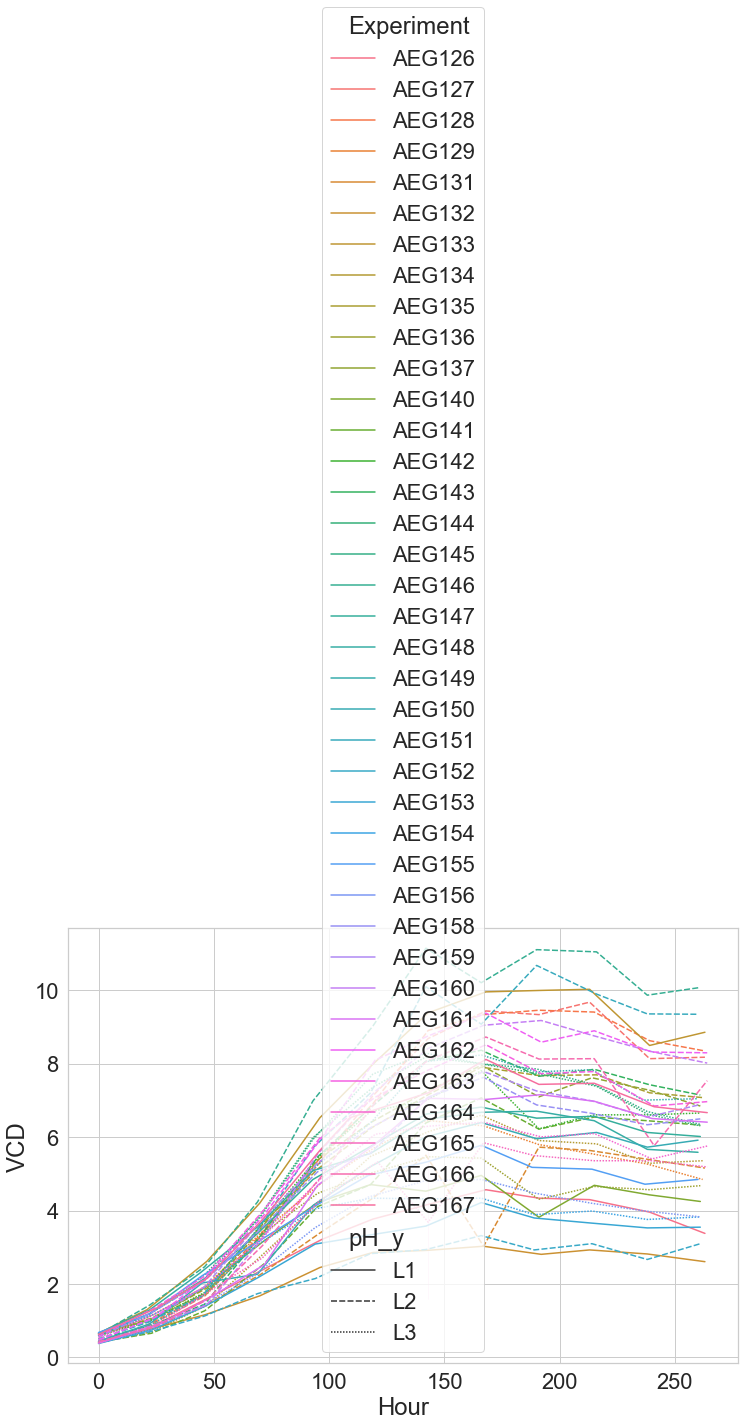

In [61]:
#plt.figure(figsize = (12,8))
#sns.lineplot(data = dat2,x = 'Hour',y = 'VCD',hue = 'Experiment',style='pH_y')


In [63]:
dat2[['Hour','Phase']]

,Hour,Phase
0,0,Exponential
1,22,Exponential
2,46,Exponential
3,70,Exponential
4,97,Stationary
...,...,...
451,168,Stationary
452,191,Stationary
453,215,Death
454,241,Death


#### NOTE: This is some data handling for multivariate analysis (not necessary for the batch functionality summary):

In [ ]:
dat_out = dat[['Glucose','Lactate','Glutamine','Glutamate','NH3','IgG','VCD','T','pH','Volume(mL)','viability','Feed_A_ADDED','Feed_B_ADDED','pH_strategy']]
dat_out_append = pd.get_dummies(dat_out['pH_strategy'])
dat_out = pd.concat([dat_out.iloc[:,:-1],dat_out_append],axis = 1)
dat_out['Day'] = dat['Day']
dat_out['Experiment'] = dat['Experiment']

# Add the Day0 VCD as inoc volume to the dataframe:
batch_ids = sorted(list(set(dat_out['Experiment'])),reverse=False,key=str.lower)
inoc_list = []
dat_subset = dat_out[dat_out['Day'] == 0]
for exp in batch_ids:
    tmp_val = dat_subset[dat_subset['Experiment'] == exp].reset_index()['VCD'][0]
    inoc_list.extend([tmp_val]*12)
#print(inoc_list)
dat_out['Inoc'] = inoc_list
dat_out = dat_out.melt(id_vars = ['Experiment','Day'],var_name='Variable',value_name='Value')
dat_out = dat_out[dat_out['Day'] != 0]
day_ids = dat_out['Day'].astype(str).tolist()
experiment_ids = dat_out['Experiment'].tolist()
res = [i + '_' + j.zfill(2) for i, j in zip(experiment_ids, day_ids)]
dat_out['New_columns'] = res
df_doe=pd.pivot_table(dat_out,index=['Variable'],values='Value',columns = 'New_columns')
print(df_doe)


# Create a dataframe from lower bounds and names of reactions to detect outliers (Multivariate and univariate):
#from collections import defaultdict
df_dict = dict()
for idxx,rxn in enumerate(df_out[0][0]):
    df_dict[rxn] = [x[idxx]/0.9 for x in df_out[1].tolist()]
#print(df_dict)

df = pd.DataFrame.from_dict(df_dict)
print(df)
list_of_variables = df.columns[1:12]
df_min = df[list_of_variables]
#print(df_min)

# Impute data:
from sklearn.impute import KNNImputer
imputah = KNNImputer()
df_min_dat = imputah.fit_transform(df_min)
#glc_up = df_min['EX_glc_e__UPTAKE'].tolist()
#lac_sec = df_min['EX_lac_L_e__SECRETION'].tolist()

figg = plt.scatter(df['EX_val_L_e__UPTAKE'],df['EX_pnto_R_e__UPTAKE'])

#from sklearn.cluster import DBSCAN
#random.seed(1)
#random_data = np.random.randn(50000,2)  * 20 + 20

#outlier_detection = DBSCAN(min_samples = 3, eps = 3)
#clusters = outlier_detection.fit_predict(df_min_dat)
#clusters
#print(list(clusters).count(-1))
from sklearn.neighbors import NearestNeighbors
n_neighbors = 10

nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(df_min_dat)
distances, indices = neighbors.kneighbors(df_min_dat)
distances = np.sort(distances[:,n_neighbors-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.savefig("Distance_curve.png", dpi=300)
import seaborn as sns
db = DBSCAN(eps=5, min_samples=10).fit(df_min_dat)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))

# Perform PCA and plot the outliers using that:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df_min_dat)

sns.scatterplot(Xt[:,0], Xt[:,1], hue=["cluster-{}".format(x) for x in labels])
#sns.scatterplot(Xt[:,0], Xt[:,1], dat[dat['Day'] != 0]['Osmolality'])
import seaborn as sns
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=5, min_samples=10).fit(df_min_dat)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))

# Perform PCA and plot the outliers using that:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df_min_dat)

sns.scatterplot(Xt[:,0], Xt[:,1], hue=["cluster-{}".format(x) for x in labels])
#sns.scatterplot(Xt[:,0], Xt[:,1], dat[dat['Day'] != 0]['Osmolality'])
import seaborn as sns
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.4, min_samples=n_neighbors).fit(df_min_dat)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))

# Perform PCA and plot the outliers using that:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df_min_dat)

sns.scatterplot(Xt[:,0], Xt[:,1], hue=["cluster-{}".format(x) for x in labels])
#sns.scatterplot(Xt[:,0], Xt[:,1], dat[dat['Day'] != 0]['Osmolality'])
import seaborn as sns
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=n_neighbors).fit(df_min_dat)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))

# Perform PCA and plot the outliers using that:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df_min_dat)

sns.scatterplot(Xt[:,0], Xt[:,1], hue=["cluster-{}".format(x) for x in labels])
#sns.scatterplot(Xt[:,0], Xt[:,1], dat[dat['Day'] != 0]['Osmolality'])
import seaborn as sns
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=n_neighbors).fit(df_min_dat)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))

# Perform PCA and plot the outliers using that:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df_min_dat)

sns.scatterplot(Xt[:,0], Xt[:,1], hue=["cluster-{}".format(x) for x in labels])
#sns.scatterplot(Xt[:,0], Xt[:,1], dat[dat['Day'] != 0]['Osmolality'])
biomass = [x[3]/0.9 for x in df_out[1].tolist()]
#import matplotlib.pyplot as plt
figg = plt.hist(biomass)
max_val = max(biomass)
print(max_val)
if max_val > 0.3:
    id_weird = biomass.index(max_val)
else:
    id_weird = np.nan

# Check last number divisable with 11 (day number) to get day of weird number in batch of interest:
#day_from_value = 0
#for test_id in range(0,12):
#    tmp_val = id_weird-test_id
#    #print(tmp_val)
#    div = tmp_val%12
#    #print(div)
#    if div == 0:
#        day_of_batch = 12-day_from_value
#        break
#    else:
#        day_from_value += 1  

day_of_batch = round((((id_weird)/11-(id_weird)//11)*11))      
print('Day in batch record:',day_of_batch)
id_ = (id_weird//11)
batch_list = sorted(set(dat['Experiment'].tolist()))
weird_batch = batch_list[id_]
print(weird_batch)
max_val = max(biomass)
print(max_val)
if max_val > 0.3:
    id_weird = biomass.index(max_val)
else:
    id_weird = np.nan

day_of_batch = round((((id_weird)/11-(id_weird)//11)*11))      
print('Day in batch record:',day_of_batch)
id_ = (id_weird//11)
batch_list = sorted(set(dat['Experiment'].tolist()))
weird_batch = batch_list[id_]
print(weird_batch)